In [22]:
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, max_error
import matplotlib.pyplot as plt

In [25]:
gb_load = joblib.load("boost_tree_model.joblib")

In [28]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

#---------- PARAMS -----------
KT = 0.199  # motors torque constant
POLE_PAIR = 21
GR = 8

# ---------------- setup ----------------
bagpath = Path("day3_trail4_forced_v7.bag")   #./day_3_trail3_v5.bag #day3_trail4_forced_v7
typestore = get_typestore(Stores.ROS2_JAZZY)


transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

required_topics = {
    '/fixposition/fpa/odomenu',
    '/motor_feedback',
    '/steering_pub'
}

rows = []

if not bagpath.exists():
    print(f"dude common ")
    exit
# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]

    for c, t, raw in reader.messages(connections=connections):

        msg = reader.deserialize(raw, c.msgtype)
        time = t * 1e-9  # ns → seconds
        time = datetime.fromtimestamp(time)

        row = {"time": time}

        # -------- odometry --------
        if c.topic == '/fixposition/fpa/odomenu':
            p = msg.pose.pose.position
            q = msg.pose.pose.orientation
            v = msg.velocity.twist.linear
            w = msg.velocity.twist.angular

            lon, lat, alt = transformer.transform(p.x, p.y, p.z)
            yaw, pitch, roll = R.from_quat(
                [q.x, q.y, q.z, q.w]
            ).as_euler("zyx", degrees=True)
            

            row.update({
                "lat": lat,
                "lon": lon,
                "alt": alt,
                "yaw": yaw,
                "pitch": pitch,
                "roll": roll,
                "vx":v.x,
                "vy":v.y,
                "vz":v.z,
                "v_speed": (v.x**2 + v.y**2) ** 0.5,
                "yaw_rate": w.x, 
                "pitch_rate": w.y,
                "roll_rate": w.z
                # "body_x": v_body[0],
                # "body_y": v_body[1],
                # "body_z": v_body[2]
            })

        # -------- motor feedback --------
        if c.topic == '/motor_feedback':
            row.update({
                "pos": msg.data[0],
                "rpm": msg.data[1]*(POLE_PAIR*GR),
                "torque": msg.data[2]*KT,
                "temp": msg.data[3],
                "err": msg.data[4]
            })

        # -------- steering --------
        if c.topic == '/steering_pub':
            row.update({
                "steering_vel": msg.linear.x
            })

        rows.append(row)

# ---------------- dataframe ----------------

df = pd.DataFrame(rows)  #.sort_values("time")
t0 = df["time"].iloc[0]
df["time"] = df["time"] - t0
# df["dt"] = df["t_rel"].diff()

# Resampled data frame 
df = df.set_index("time").resample("100ms").mean().interpolate()
df.yaw = df.yaw*np.pi/180
df['uncorrect_yaw'] = df.yaw
df.yaw = np.unwrap(df.yaw)


DT = 0.1

def data_augment( df: pd.DataFrame  ):
    beta_data = np.arctan(df['vy'] / (df['vx'])).rolling(window = 2 , min_periods=1).mean()

    # yaw_term_data = data['yaw_rate'] / (data['v_speed'] + 1e-6)
    yaw_term_data = df['yaw'].diff().bfill()/DT / (df['v_speed'] + 1e-6)

    pos_data = df['pos']*np.pi/180

    steering_spd = df['rpm']

    steering_acel = df['rpm'].diff()

    df['beta'] = beta_data
    df['yaw_term'] = yaw_term_data
    df['pos'] = pos_data
    df['steering_spd'] = steering_spd
    df['steering_acel'] = steering_acel
    
    return df

df = data_augment(df) 

# 2. FEATURE ENGINEERING
# Base state variables
base_features = ['pos', 'steering_spd', 'steering_acel', 'roll', 'vx' , 'vy' , 'pitch' , 'yaw' , 'beta' , 'yaw_term' , 'v_speed' ]


lags = [1,2,3,4,5,10] 
memory_cols = []

# Loop includes 'torque' because we want Auto-Regression (using past torque to predict new torque)
for feat in base_features + ['torque']: 
    for lag in lags:
        col_name = f'{feat}_lag_{lag}'
        df[col_name] = df[feat].shift(lag) # <--- CRITICAL STEP
        memory_cols.append(col_name)


df['vel_trend_10'] = df['steering_spd'].rolling(window=10).mean()
df['torque_smooth_10'] = df['torque_lag_1'].ewm(span=10).mean() # separately done to avoid leaking 
df['torque_smooth_5'] = df['torque_lag_1'].ewm(span=5).mean() # separately done to avoid leaking 

rols = [5 , 10]
for feat in base_features: 
    for lag in rols:
        col_name = f'{feat}_smooth_{lag}'
        df[col_name] = df[feat].ewm(span=lag).mean() # <--- CRITICAL STEP
        memory_cols.append(col_name)

diff = [1 , 2, 3, 4]
for feat in base_features + ['torque_lag_1']: 
    for lag in diff:
        col_name = f'{feat}_diff_{lag}'
        df[col_name] = df[feat].diff(periods=lag) # <--- CRITICAL STEP
        memory_cols.append(col_name)

memory_cols.extend(['vel_trend_10', 'torque_smooth_10' , 'torque_smooth_5'])

df = df.interpolate().bfill()

# Filter for moving vehicle only (Static friction is chaotic and irrelevant for driving)
df = df[df['v_speed'].abs() > 0.15]

predictors = base_features + memory_cols
target = 'torque'

# rf_narx = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
# rf_narx.fit(df[predictors], df[target])

# gb_best = GradientBoostingRegressor(
#     n_estimators=100,
#     max_depth=11,
#     learning_rate=0.037,
#     random_state=0
# )
# gb_best.fit(df[predictors], df[target])

# y_out = gb_best.predict(df[predictors])
# rmse = np.sqrt(mean_squared_error(df[target], y_out))
# print(f"train errr = {rmse}")


# print(f"\n--- RESULTS ---")
# print(f"RMSE: {rmse:.4f} Nm")

# # importances = rf_narx.feature_importances_
# # # importances
# # # len(predictors)
# # for i in range(len(predictors)):
# #     if importances[i] > 0.01:
# #         print(f" '{predictors[i]}', : {importances[i]}")



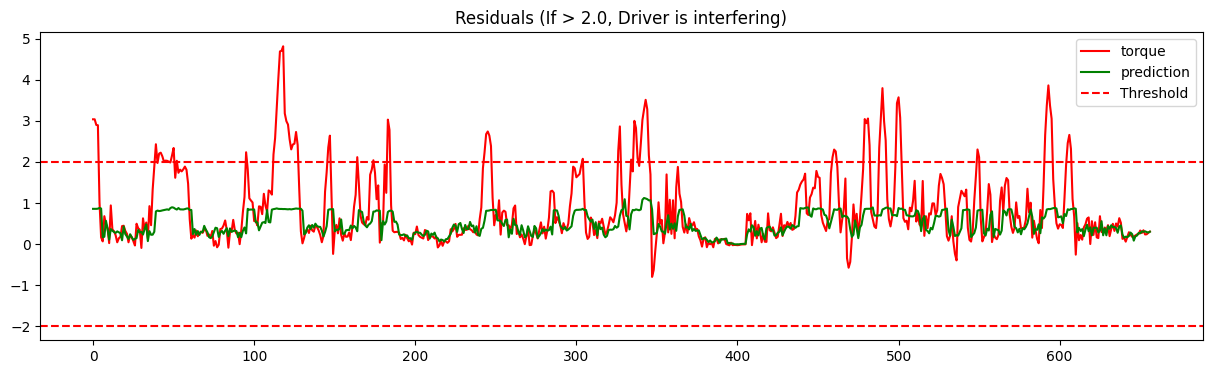

In [ ]:

y_pred = gb_load.predict(df[predictors])
std = y_pred.std()


# 9. PLOT RESIDUALS (Your Takeover Signal)
residuals = df[target].values - y_pred
plt.figure(figsize=(15, 4))
# plt.plot(residuals, 'b', label='Prediction Error')
plt.plot(df.torque.values, 'r', label='torque')
plt.plot(y_pred, 'g', label='prediction')
plt.axhline(2.0, color='r', linestyle='--', label='Threshold')
plt.axhline(-2.0, color='r', linestyle='--')
plt.title("Residuals (If > 2.0, Driver is interfering)")
plt.legend()
plt.show()

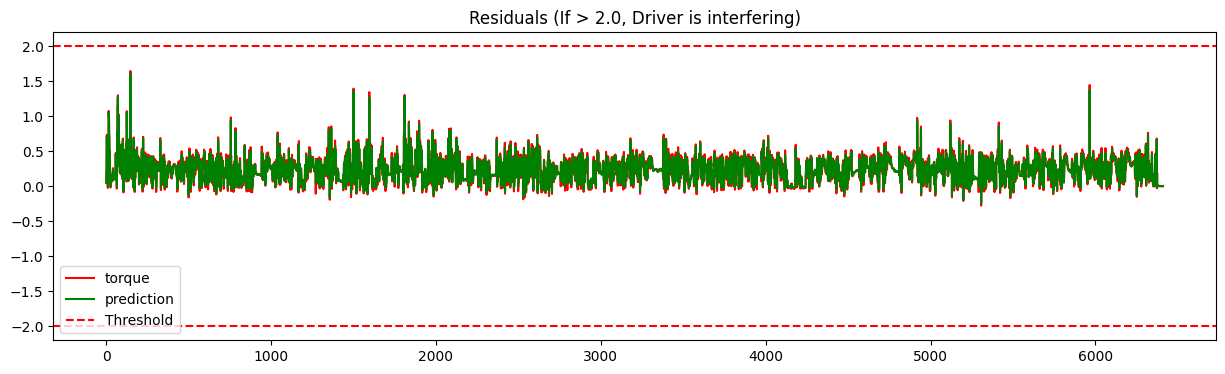

In [26]:
y_pred = gb_load.predict(df[predictors])
std = y_pred.std()


# 9. PLOT RESIDUALS (Your Takeover Signal)
residuals = df[target].values - y_pred
plt.figure(figsize=(15, 4))
# plt.plot(residuals, 'b', label='Prediction Error')
plt.plot(df.torque.values, 'r', label='torque')
plt.plot(y_pred, 'g', label='prediction')
plt.axhline(2.0, color='r', linestyle='--', label='Threshold')
plt.axhline(-2.0, color='r', linestyle='--')
plt.title("Residuals (If > 2.0, Driver is interfering)")
plt.legend()
plt.show()

In [27]:
rmse = np.sqrt(mean_squared_error(df[target], y_pred))
print(f"train errr = {rmse}")

train errr = 0.02298164694860606


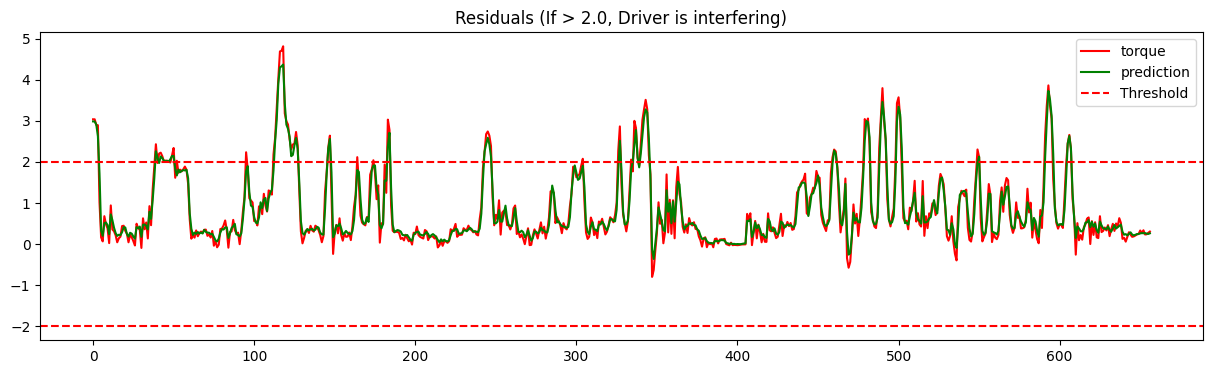

In [ ]:
y_pred = rf_loaded.predict(df[predictors])
std = y_pred.std()


# 9. PLOT RESIDUALS (Your Takeover Signal)
residuals = df[target].values - y_pred
plt.figure(figsize=(15, 4))
# plt.plot(residuals, 'b', label='Prediction Error')
plt.plot(df.torque.values, 'r', label='torque')
plt.plot(y_pred, 'g', label='prediction')
plt.axhline(2.0, color='r', linestyle='--', label='Threshold')
plt.axhline(-2.0, color='r', linestyle='--')
plt.title("Residuals (If > 2.0, Driver is interfering)")
plt.legend()
plt.show()